In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

UROMOL = pd.read_csv('./UROMOL_TaLG.teachingcohort.csv')
UROMOL.drop(columns=['Unnamed: 0', 'Progression', 'PFS_time.'], inplace=True)

knowles = pd.read_csv('./knowles_matched_TaLG_final.csv')

# only keep columns that are in both datasets
common_cols = knowles.columns.intersection(UROMOL.columns)
UROMOL = UROMOL[common_cols]
knowles = knowles[common_cols]

catagorical_vars = ['Sex', 'Tumor.stage', 'Tumor.grade', 'Concomitant.CIS', 'UROMOL2021.classification']

# drop rows that have missing target values
UROMOL['RFS_time'] = UROMOL.apply(lambda row: row['FUtime_days.'] / 30 if pd.isna(row['RFS_time']) and row['Recurrence'] == 0 else row['RFS_time'], axis=1)
UROMOL = UROMOL.dropna(subset=['Recurrence', 'RFS_time'])

knowles['RFS_time'] = knowles.apply(lambda row: row['FUtime_days.'] / 30 if pd.isna(row['RFS_time']) and row['Recurrence'] == 0 else row['RFS_time'], axis=1)
knowles = knowles.dropna(subset=['Recurrence', 'RFS_time'])

knowles['UROMOL2021.classification'] = knowles['UROMOL2021.classification'].str.replace('_', ' ')
UROMOL['Tumor.grade'] = UROMOL['Tumor.grade'].str.replace(' grade', '')

knowles.drop(columns=['FUtime_days.'], inplace=True)
UROMOL.drop(columns=['FUtime_days.'], inplace=True)

print(UROMOL.shape, knowles.shape)

combined = pd.concat([UROMOL, knowles])
combined.reset_index(drop=True, inplace=True)

# one hot encoding
enc = OneHotEncoder(handle_unknown='ignore', drop='if_binary')
enc.fit(combined[catagorical_vars])
combined_encoded = enc.transform(combined[catagorical_vars]).toarray()
combined_encoded = pd.DataFrame(combined_encoded, columns=enc.get_feature_names_out(catagorical_vars))

# Drop original columns and add encoded columns
combined.drop(columns=catagorical_vars, inplace=True)
combined = pd.concat([combined, combined_encoded], axis=1)

# Impute missing values
imputer = KNNImputer(n_neighbors=5, weights='distance')
combined_imputed = pd.DataFrame(imputer.fit_transform(combined), columns=combined.columns)

# Normalize
scaler = StandardScaler()
target = combined_imputed[['Recurrence', 'RFS_time']]
combined_imputed.drop(columns=['Recurrence', 'RFS_time'], inplace=True)
combined_normalized = pd.DataFrame(scaler.fit_transform(combined_imputed), columns=combined_imputed.columns)
combined_normalized = pd.concat([combined_normalized, target], axis=1)

# Separate the datasets
UROMOL_normalized = combined_normalized.iloc[:UROMOL.shape[0], :]
knowles_normalized = combined_normalized.iloc[UROMOL.shape[0]:, :]

print(UROMOL_normalized.shape, knowles_normalized.shape)

(276, 19096) (72, 19096)
(276, 19099) (72, 19099)


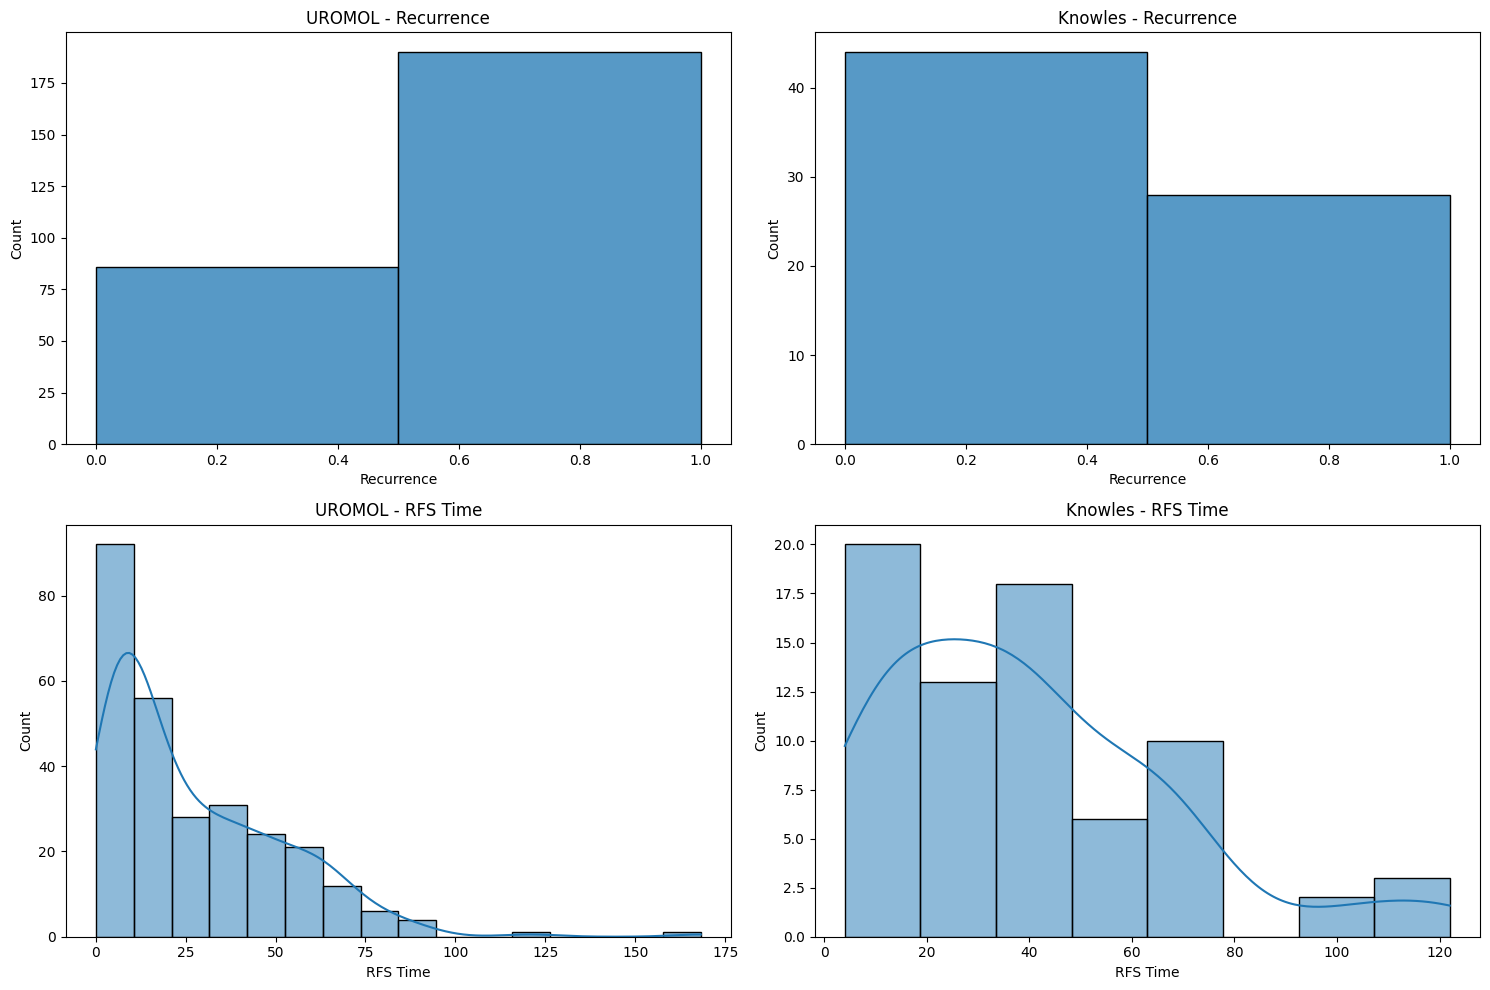

In [5]:
# plot the distribution of the target variable
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(UROMOL_normalized['Recurrence'], bins=2, kde=False)
plt.title('UROMOL - Recurrence')
plt.xlabel('Recurrence')

plt.subplot(2, 2, 2)
sns.histplot(knowles_normalized['Recurrence'], bins=2, kde=False)
plt.title('Knowles - Recurrence')
plt.xlabel('Recurrence')

plt.subplot(2, 2, 3)
sns.histplot(UROMOL_normalized['RFS_time'], kde=True)
plt.title('UROMOL - RFS Time')
plt.xlabel('RFS Time')

plt.subplot(2, 2, 4)
sns.histplot(knowles_normalized['RFS_time'], kde=True)
plt.title('Knowles - RFS Time')
plt.xlabel('RFS Time')

plt.tight_layout()
plt.show()


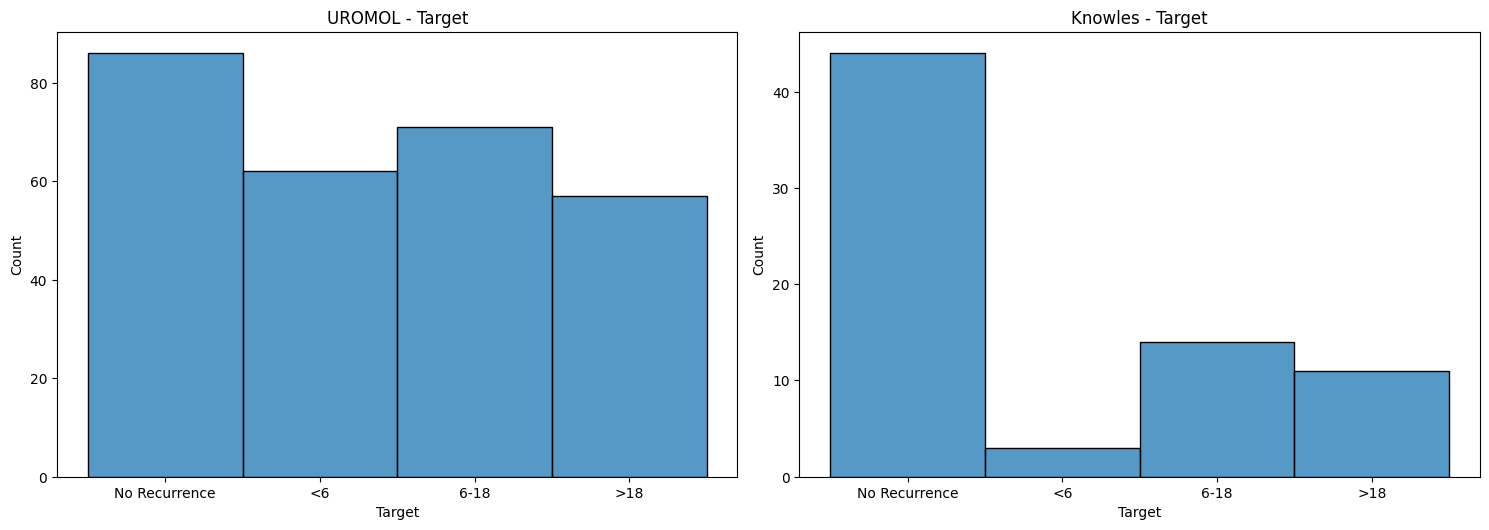

In [6]:
# bin the RFS to less than 3 months, 3-6 months, 6-18 months, more than 18 months, and no recurrence

# Bin the RFS to less than 6 months, 6-18 months, more than 18 months
UROMOL_normalized['RFS_time'] = pd.cut(UROMOL_normalized['RFS_time'], bins=[0, 6, 18, 1000], labels=['<6', '6-18', '>18'])
knowles_normalized['RFS_time'] = pd.cut(knowles_normalized['RFS_time'], bins=[0, 6, 18, 1000], labels=['<6', '6-18', '>18'])

# Create a new column 'Target' based on the condition
UROMOL_normalized['Target'] = UROMOL_normalized.apply(lambda row: 'No Recurrence' if row['Recurrence'] == 0 else row['RFS_time'], axis=1)
knowles_normalized['Target'] = knowles_normalized.apply(lambda row: 'No Recurrence' if row['Recurrence'] == 0 else row['RFS_time'], axis=1)

UROMOL_normalized.drop(columns=['Recurrence', 'RFS_time'], inplace=True)
knowles_normalized.drop(columns=['Recurrence', 'RFS_time'], inplace=True)

# plot the distribution of the target variable
plt.figure(figsize=(15, 10))

temp = pd.Categorical(UROMOL_normalized['Target'], categories=['No Recurrence', '<6', '6-18', '>18'], ordered=True)

plt.subplot(2, 2, 1)
sns.histplot(temp, bins=4, kde=False)
plt.title('UROMOL - Target')
plt.xlabel('Target')

temp = pd.Categorical(knowles_normalized['Target'], categories=['No Recurrence', '<6', '6-18', '>18'], ordered=True)

plt.subplot(2, 2, 2)
sns.histplot(temp, bins=4, kde=False)
plt.title('Knowles - Target')
plt.xlabel('Target')

plt.tight_layout()
plt.show()

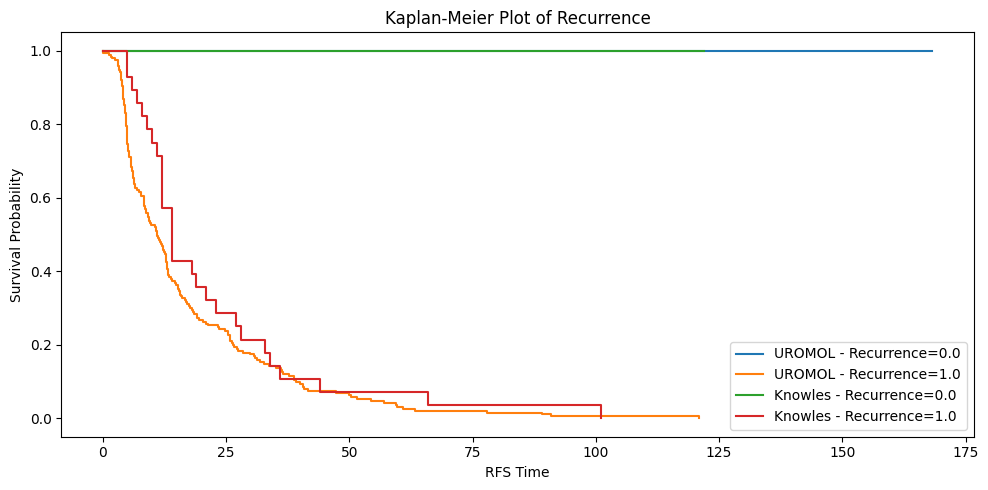

In [13]:
from lifelines import KaplanMeierFitter

plt.figure(figsize=(10, 5))

kmf = KaplanMeierFitter()

plt.subplot(1, 1, 1)
for label, group in UROMOL.groupby('Recurrence'):
    kmf.fit(group['RFS_time'], event_observed=group['Recurrence'])
    kmf.plot_survival_function(label=f'UROMOL - Recurrence={label}', ci_show=False)

for label, group in knowles.groupby('Recurrence'):
    kmf.fit(group['RFS_time'], event_observed=group['Recurrence'])
    kmf.plot_survival_function(label=f'Knowles - Recurrence={label}', ci_show=False)

plt.title('Kaplan-Meier Plot of Recurrence')
plt.xlabel('RFS Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

X = UROMOL_normalized.drop(columns=['Target'])
y = UROMOL_normalized['Target']
y = pd.get_dummies(y)
classes = y.columns
y = np.argmax(y.values, axis=1)

X_val = knowles_normalized.drop(columns=['Target'])
y_val = knowles_normalized['Target']
y_val = pd.get_dummies(y_val)
classes_val = y_val.columns
y_val = np.argmax(y_val.values, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
rfe = RFE(model, n_features_to_select=20, step=0.01)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print(selected_features)

Index(['exprs.DSC2', 'exprs.RSU1', 'exprs.PIH1D2', 'exprs.HSF2BP',
       'exprs.IL23R', 'exprs.FLVCR1', 'exprs.IVL', 'exprs.PTPN13',
       'exprs.ZC3H12A', 'exprs.ARHGEF3', 'exprs.MST1R', 'exprs.APBB1',
       'exprs.BEST1', 'exprs.TMEM208', 'exprs.MFF', 'exprs.NDUFA3',
       'exprs.DCAKD', 'exprs.HHIPL1', 'exprs.TNFAIP8L3', 'exprs.IFITM2'],
      dtype='object')


# SHAP plot

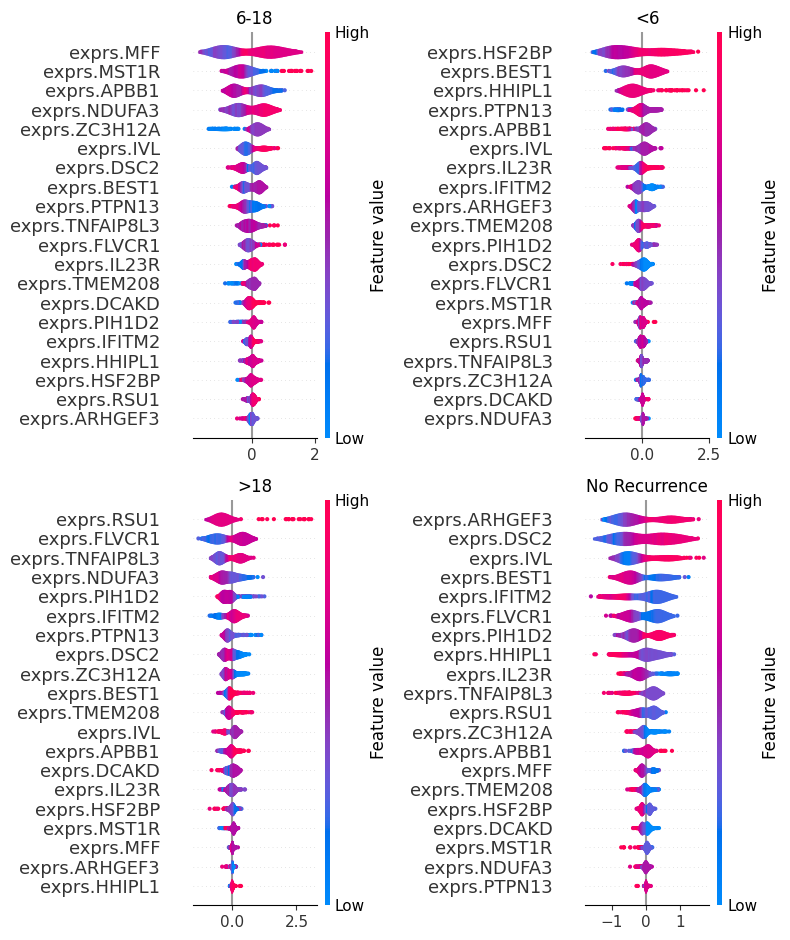

In [9]:
import shap

model = xgb.XGBClassifier(n_estimators=100, random_state=seed, n_jobs=-1).fit(X_train[selected_features], y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[selected_features])

plt.figure(figsize=(20, 15))

for i in range(len(classes)):
    plt.subplot(2, 2, i + 1)
    shap.summary_plot(shap_values[:,:,i], X_train[selected_features], plot_type='violin', show=False, max_display=20)
    plt.title(f'{classes[i]}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

# XGboost RFE

internal validation


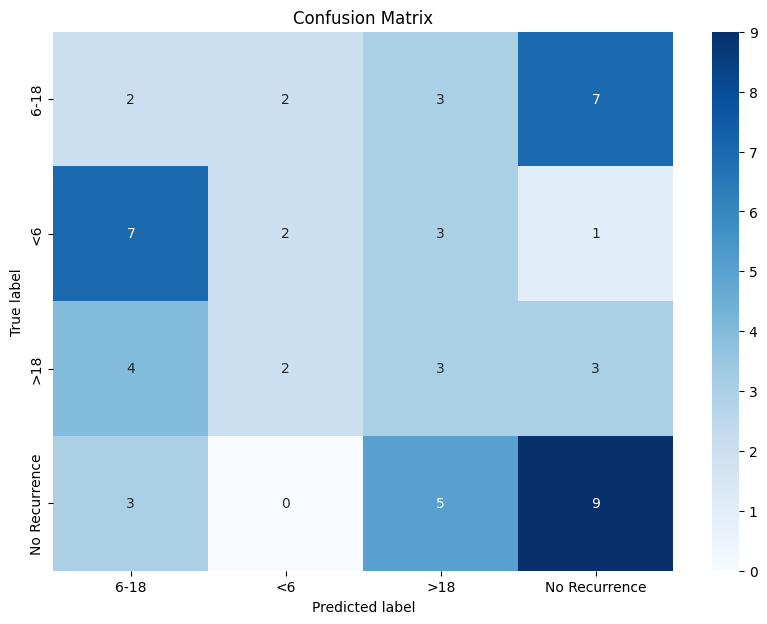

Accuracy: 0.2690287653522948
Precision: 0.29115646258503397
Recall: 0.2857142857142857
F1 Score: 0.2793394609184083
AUC: 0.5599743790425586
-------------------------------------------------------------
external validation


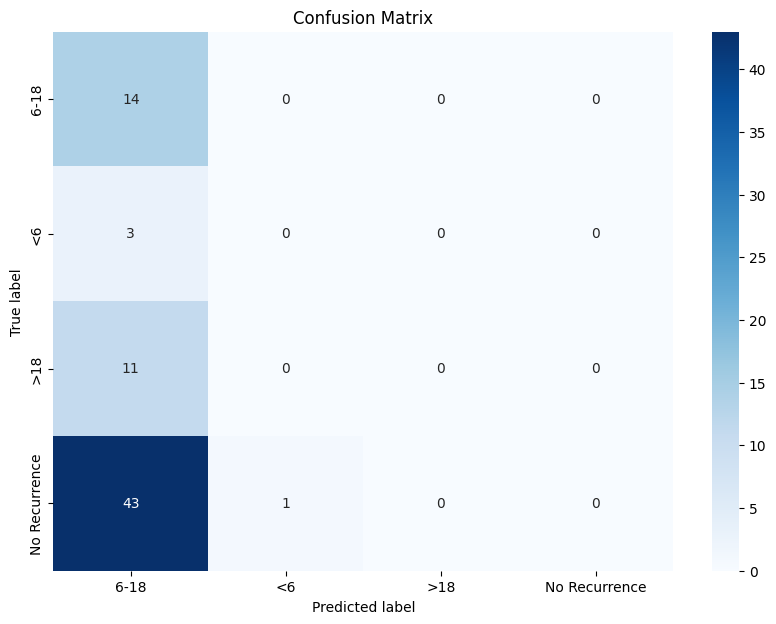

Accuracy: 0.25
Precision: 0.03834115805946792
Recall: 0.19444444444444445
F1 Score: 0.06405228758169934
AUC: 0.4646824115619431


In [15]:
from sklearn import metrics

model = xgb.XGBClassifier(n_estimators=1000, random_state=seed, n_jobs=-1)
model.fit(X_train[selected_features], y_train)

y_score = model.predict_proba(X_test[selected_features])
y_pred = np.argmax(y_score, axis=1)

print('internal validation')
plot_cm(y_test, y_pred, classes)
print(f'Accuracy: {metrics.balanced_accuracy_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {metrics.recall_score(y_test, y_pred, average="weighted")}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'AUC: {metrics.roc_auc_score(y_test, y_score, multi_class="ovr")}')
print('-------------------------------------------------------------')

y_score_val = model.predict_proba(X_val[selected_features])
y_val_pred = np.argmax(y_score_val, axis=1)

print('external validation')
plot_cm(y_val, y_val_pred, classes_val)
print(f'Accuracy: {metrics.balanced_accuracy_score(y_val, y_val_pred)}')
print(f'Precision: {metrics.precision_score(y_val, y_val_pred, average="weighted")}')
print(f'Recall: {metrics.recall_score(y_val, y_val_pred, average="weighted")}')
print(f'F1 Score: {metrics.f1_score(y_val, y_val_pred, average="weighted")}')
print(f'AUC: {metrics.roc_auc_score(y_val, y_score_val, multi_class="ovr")}')

# XGboost PCA

0.6088030940318225
internal validation


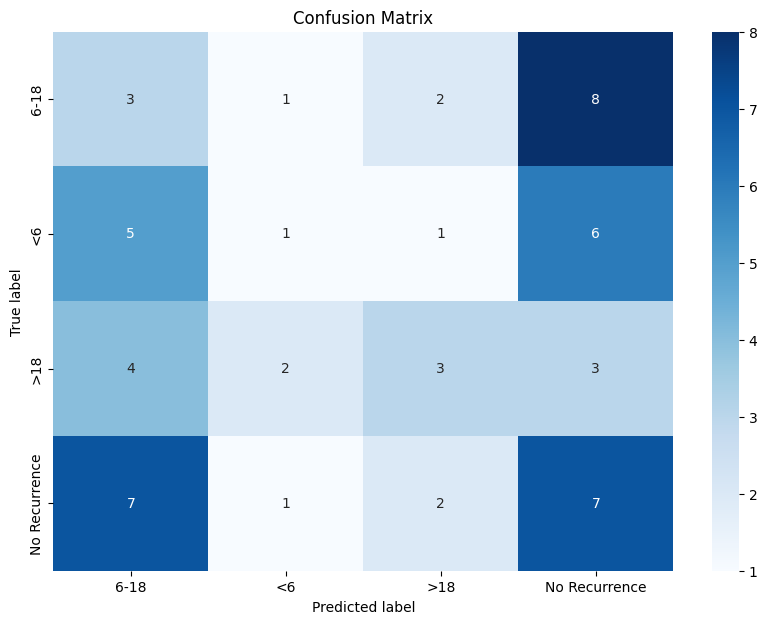

Accuracy: 0.23824337427278602
Precision: 0.2548010651629073
Recall: 0.25
F1 Score: 0.2391924471192764
AUC: 0.5455113375647869
-------------------------------------------------------------
external validation


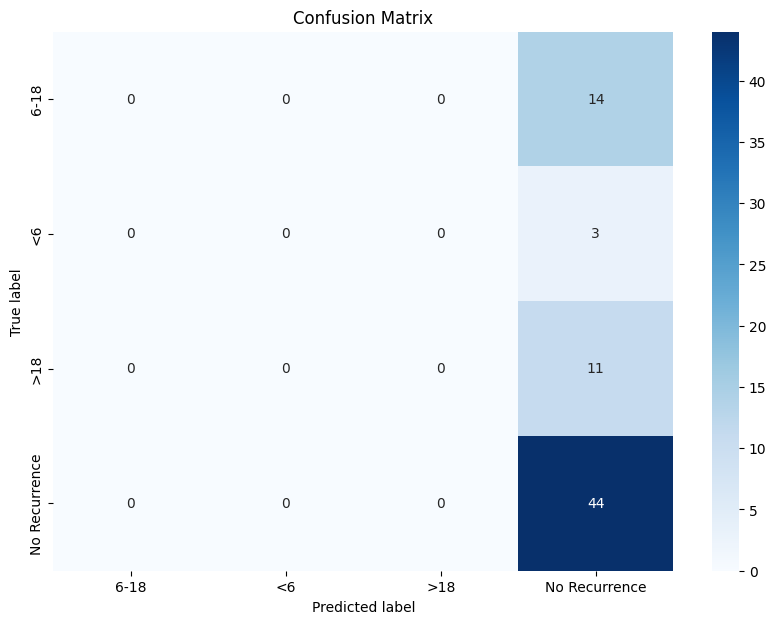

Accuracy: 0.25
Precision: 0.37345679012345684
Recall: 0.6111111111111112
F1 Score: 0.46360153256704983
AUC: 0.5403916794264141


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=seed)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.explained_variance_ratio_.sum())

model = xgb.XGBClassifier(n_estimators=1000, random_state=seed, n_jobs=-1)
model.fit(X_train_pca, y_train)

y_score = model.predict_proba(X_test_pca)
y_pred = np.argmax(y_score, axis=1)

print('internal validation')
plot_cm(y_test, y_pred, classes)
print(f'Accuracy: {metrics.balanced_accuracy_score(y_test, y_pred)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {metrics.recall_score(y_test, y_pred, average="weighted")}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred, average="weighted")}')
print(f'AUC: {metrics.roc_auc_score(y_test, y_score, multi_class="ovr")}')
print('-------------------------------------------------------------')

X_val_pca = pca.transform(X_val)
y_val_score = model.predict_proba(X_val_pca)
y_val_pred = np.argmax(y_val_score, axis=1)

print('external validation')
plot_cm(y_val, y_val_pred, classes_val)
print(f'Accuracy: {metrics.balanced_accuracy_score(y_val, y_val_pred)}')
print(f'Precision: {metrics.precision_score(y_val, y_val_pred, average="weighted")}')
print(f'Recall: {metrics.recall_score(y_val, y_val_pred, average="weighted")}')
print(f'F1 Score: {metrics.f1_score(y_val, y_val_pred, average="weighted")}')
print(f'AUC: {metrics.roc_auc_score(y_val, y_val_score, multi_class="ovr")}')

# NN RFE

{0: 0.971830985915493, 1: 1.1129032258064515, 2: 1.2105263157894737, 3: 0.8023255813953488}


best hyperparameters: (20, 64, 256, 256, 0.4, 0.0001)
Index(['exprs.HS3ST1', 'exprs.PRSS22', 'exprs.BAIAP2L1', 'exprs.SCML1',
       'exprs.TM7SF3', 'exprs.NID2', 'exprs.SLC17A9', 'exprs.RABAC1',
       'exprs.OAS3', 'exprs.ARL4A', 'exprs.RAB38', 'exprs.ZBP1', 'exprs.FGF13',
       'exprs.SPOCD1', 'exprs.DSC2', 'exprs.TRIM29', 'exprs.FRMD6',
       'exprs.TMEM198', 'exprs.TOX', 'exprs.MAN1B1-DT'],
      dtype='object')


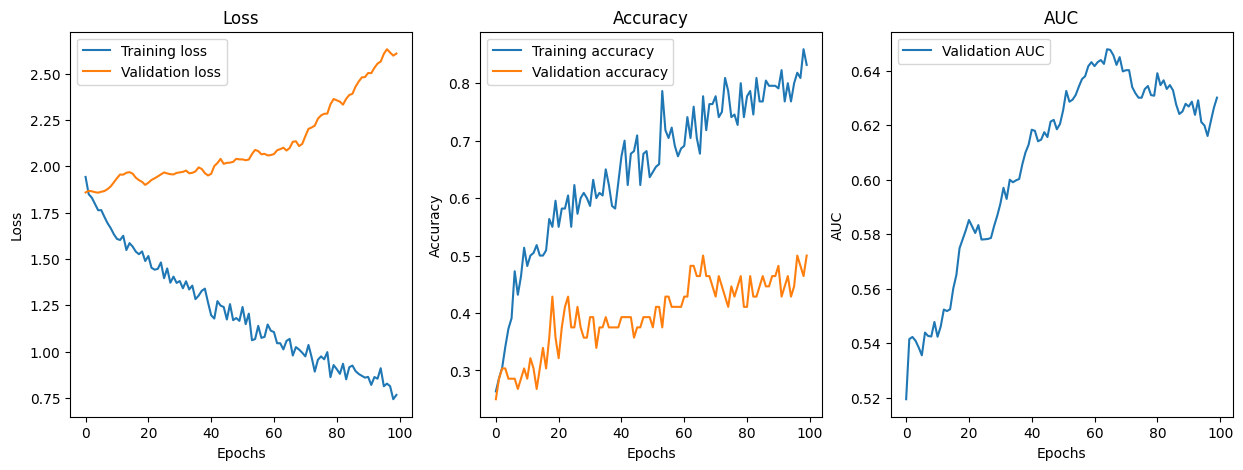


1/2 [==============>...............] - ETA: 0s


2/2 [==============================] - 0s 2ms/step


internal validation


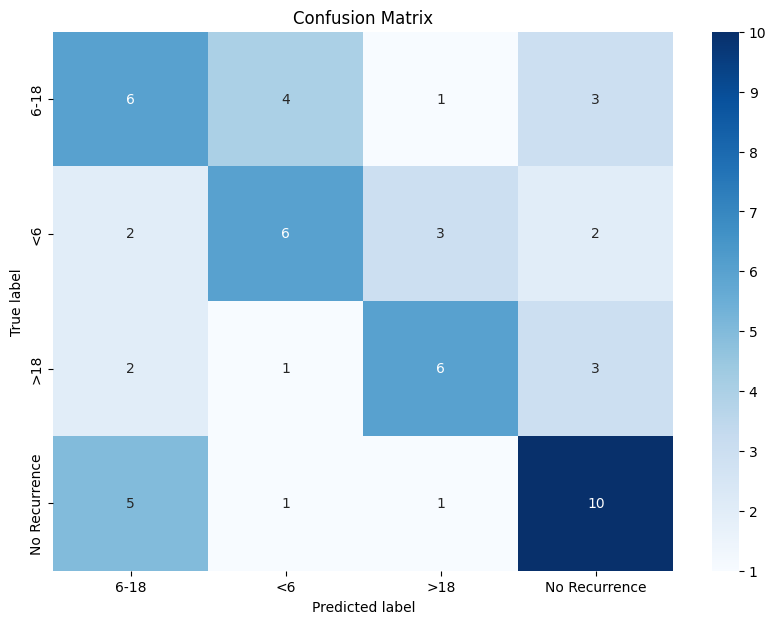

Accuracy: 0.4945862960568843
Precision: 0.5016053391053391
Recall: 0.5
F1 Score: 0.5001474772817672
AUC: 0.6301629571978409
-------------------------------------------------------------

1/3 [=========>....................] - ETA: 0s


3/3 [==============================] - 0s 1ms/step


external validation


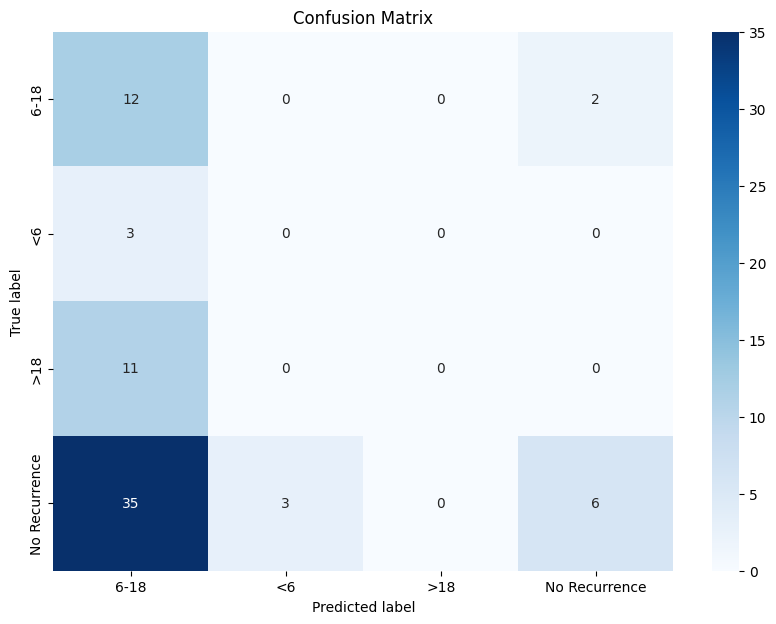

Accuracy: 0.24837662337662336
Precision: 0.49658469945355194
Recall: 0.25
F1 Score: 0.20324786324786326
AUC: 0.4529268962983202


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1
from sklearn.utils.class_weight import compute_class_weight

# Define a function to create the model with given hyperparameters
def create_model(unit_1, unit_2, unit_3, dropout_rate, reg_rate):
    model = Sequential()
    if unit_1 > 0:
        model.add(Dense(unit_1, activation="relu", kernel_regularizer=l1(reg_rate)))
        model.add(Dropout(dropout_rate))
    if unit_2 > 0:
        model.add(Dense(unit_2, activation="relu", kernel_regularizer=l1(reg_rate)))
        model.add(Dropout(dropout_rate))
    if unit_3 > 0:
        model.add(Dense(unit_3, activation="relu", kernel_regularizer=l1(reg_rate)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation="softmax", kernel_regularizer=l1(reg_rate)))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Define hyperparameters to try
n_features = [20, 50, 100]
units_list_1 = [64, 128, 256]
units_list_2 = [0, 128, 256]
units_list_3 = [0, 256, 512]
dropout_rate_list = [0.3, 0.4, 0.5]
reg_rate_list = [0.01, 0.001, 0.0001]

best_auc = 0
best_model = None
best_hyperparameters = None
history_antibody = None
best_selected_features = None

class AUCTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_test[selected_features], verbose=0)
        auc = metrics.roc_auc_score(y_test, y_pred, multi_class="ovr")
        logs['val_auc'] = auc
        f1 = metrics.f1_score(y_test, np.argmax(y_pred, axis=1), average="weighted")
        logs['val_f1'] = f1
        balanced_accuracy = metrics.balanced_accuracy_score(y_test, np.argmax(y_pred, axis=1))
        logs['val_balanced_accuracy'] = balanced_accuracy

auc_tracker = AUCTracker()

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

# Train models with different hyperparameters
for n_feature in n_features:
    model = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rfe = RFE(model, n_features_to_select=n_feature, step=0.01)
    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    for units_1 in units_list_1:
        for units_2 in units_list_2:
            for units_3 in units_list_3:
                for dropout_rate in dropout_rate_list:
                    for reg_rate in reg_rate_list:
                        model = create_model(units_1, units_2, units_3, dropout_rate, reg_rate)
                        history = model.fit(X_train[selected_features], y_train, epochs=100, batch_size=32, validation_data=(X_test[selected_features], y_test), 
                                            class_weight=class_weights, callbacks=[auc_tracker], verbose=0)
                        if history.history["val_balanced_accuracy"][-1] > best_auc:
                            best_auc = history.history["val_balanced_accuracy"][-1]
                            best_model = model
                            best_hyperparameters = (n_feature, units_1, units_2, units_3, dropout_rate, reg_rate)
                            best_selected_features = selected_features
                            history_antibody = history

selected_features = best_selected_features
print(f'best hyperparameters: {best_hyperparameters}')
print(selected_features)

# plot the training and validation loss and accuracy side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
ax1.plot(history_antibody.history["loss"], label="Training loss")
ax1.plot(history_antibody.history["val_loss"], label="Validation loss")
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# plot accuracy
ax2.plot(history_antibody.history["accuracy"], label="Training accuracy")
ax2.plot(history_antibody.history["val_accuracy"], label="Validation accuracy")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# plot AUC
ax3.plot(history_antibody.history["val_auc"], label="Validation AUC")
ax3.set_title("AUC")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("AUC")
ax3.legend()

plt.show()

# Get class predictions
y_score = (best_model.predict(X_test[selected_features])).astype("float64")
y_pred = np.argmax(y_score, axis=1)

print('internal validation')
plot_cm(y_test, y_pred, classes)
print("Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:", metrics.recall_score(y_test, y_pred, average="weighted"))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average="weighted"))
print("AUC:", metrics.roc_auc_score(y_test, y_score, multi_class="ovr"))
print('-------------------------------------------------------------')

y_score_val = (best_model.predict(X_val[selected_features])).astype("float64")
y_pred_val = np.argmax(y_score_val, axis=1)

print('external validation')
plot_cm(y_val, y_pred_val, classes_val)
print("Accuracy:", metrics.balanced_accuracy_score(y_val, y_pred_val))
print("Precision:", metrics.precision_score(y_val, y_pred_val, average="weighted"))
print("Recall:", metrics.recall_score(y_val, y_pred_val, average="weighted"))
print("F1 Score:", metrics.f1_score(y_val, y_pred_val, average="weighted"))
print("AUC:", metrics.roc_auc_score(y_val, y_score_val, multi_class="ovr"))

# NN PCA

{0: 0.971830985915493, 1: 1.1129032258064515, 2: 1.2105263157894737, 3: 0.8023255813953488}


best hyperparameters: (100, 128, 256, 512, 0.5, 0.0001)


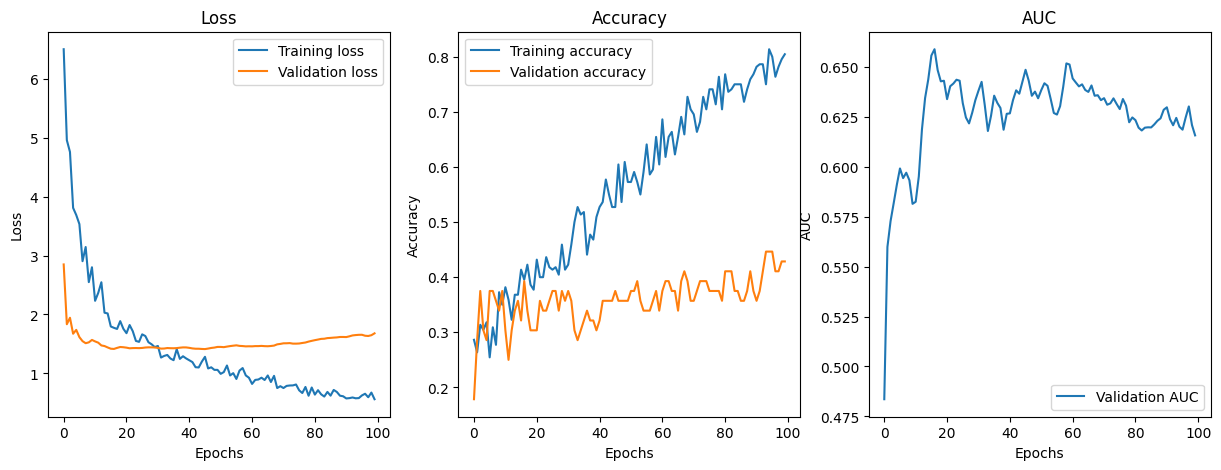

internal validation


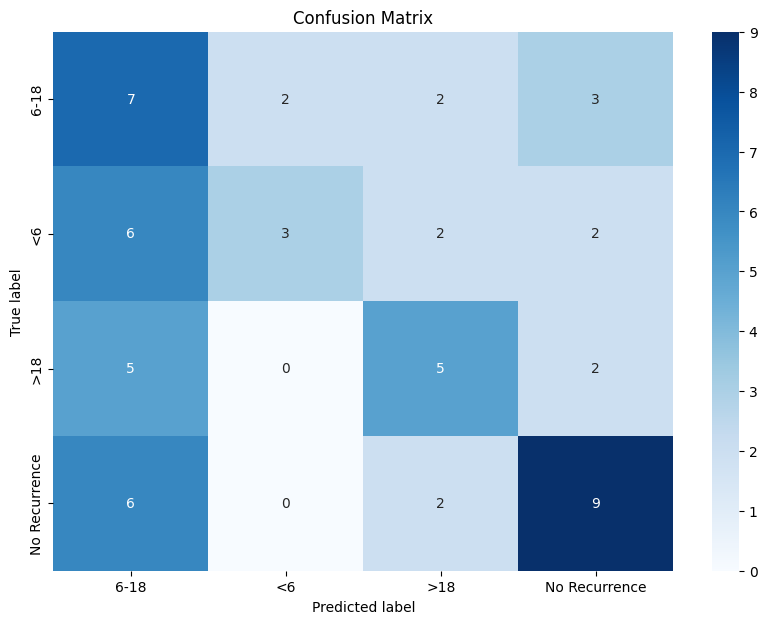

Accuracy: 0.419211915535445
Precision: 0.4803639069264069
Recall: 0.42857142857142855
F1 Score: 0.42823833298661673
AUC: 0.6157437177993657
-------------------------------------------------------------
external validation


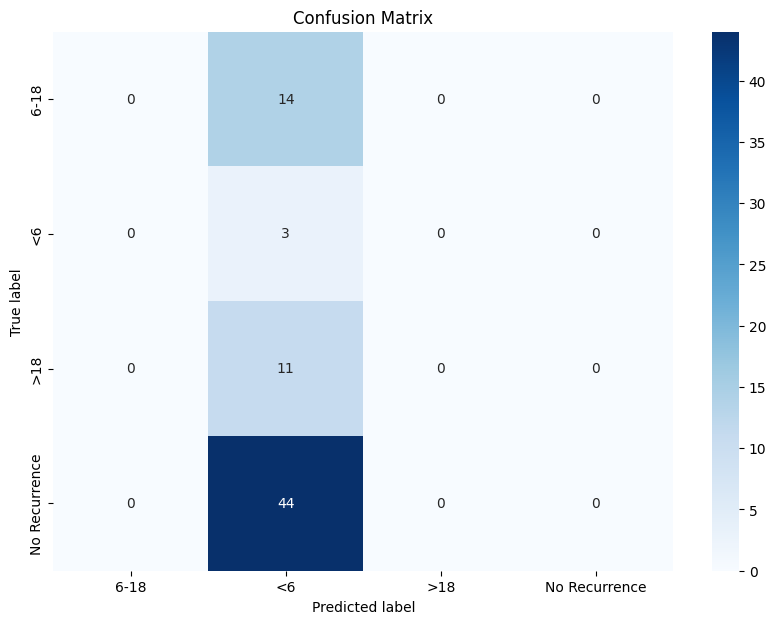

Accuracy: 0.25
Precision: 0.001736111111111111
Recall: 0.041666666666666664
F1 Score: 0.003333333333333333
AUC: 0.6006198186301782


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Define a function to create the model with given hyperparameters
def create_model(unit_1, unit_2, unit_3, dropout_rate, reg_rate):
    model = Sequential()
    if unit_1 > 0:
        model.add(Dense(unit_1, activation="relu", kernel_regularizer=l2(reg_rate)))
        model.add(Dropout(dropout_rate))
    if unit_2 > 0:
        model.add(Dense(unit_2, activation="relu", kernel_regularizer=l2(reg_rate)))
        model.add(Dropout(dropout_rate))
    if unit_3 > 0:
        model.add(Dense(unit_3, activation="relu", kernel_regularizer=l2(reg_rate)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation="softmax", kernel_regularizer=l2(reg_rate)))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Define hyperparameters to try
n_features = [20, 50, 100]
units_list_1 = [64, 128, 256]
units_list_2 = [0, 128, 256]
units_list_3 = [0, 256, 512]
dropout_rate_list = [0.3, 0.4, 0.5]
reg_rate_list = [0.01, 0.001, 0.0001]

best_auc = 0
best_model = None
best_hyperparameters = None
history_antibody = None
best_pca = None

class AUCTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_test_pca, verbose=0)
        auc = metrics.roc_auc_score(y_test, y_pred, multi_class="ovr")
        logs['val_auc'] = auc
        f1 = metrics.f1_score(y_test, np.argmax(y_pred, axis=1), average="weighted")
        logs['val_f1'] = f1
        balanced_accuracy = metrics.balanced_accuracy_score(y_test, np.argmax(y_pred, axis=1))
        logs['val_balanced_accuracy'] = balanced_accuracy

auc_tracker = AUCTracker()

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

# Train models with different hyperparameters
for n_feature in n_features:
    pca = PCA(n_components=n_feature, random_state=seed)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    for units_1 in units_list_1:
        for units_2 in units_list_2:
            for units_3 in units_list_3:
                for dropout_rate in dropout_rate_list:
                    for reg_rate in reg_rate_list:
                        model = create_model(units_1, units_2, units_3, dropout_rate, reg_rate)
                        history = model.fit(X_train_pca, y_train, epochs=100, batch_size=32, validation_data=(X_test_pca, y_test), 
                                            class_weight=class_weights, callbacks=[auc_tracker], verbose=0)
                        if history.history["val_balanced_accuracy"][-1] > best_auc:
                            best_auc = history.history["val_balanced_accuracy"][-1]
                            best_model = model
                            best_hyperparameters = (n_feature, units_1, units_2, units_3, dropout_rate, reg_rate)
                            history_antibody = history
                            best_pca = pca

pca = best_pca
print(f'best hyperparameters: {best_hyperparameters}')

# plot the training and validation loss and accuracy side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
ax1.plot(history_antibody.history["loss"], label="Training loss")
ax1.plot(history_antibody.history["val_loss"], label="Validation loss")
ax1.set_title("Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

# plot accuracy
ax2.plot(history_antibody.history["accuracy"], label="Training accuracy")
ax2.plot(history_antibody.history["val_accuracy"], label="Validation accuracy")
ax2.set_title("Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

# plot AUC
ax3.plot(history_antibody.history["val_auc"], label="Validation AUC")
ax3.set_title("AUC")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("AUC")
ax3.legend()

plt.show()

# Get class predictions
y_score = (best_model.predict(pca.transform(X_test), verbose=0)).astype("float64")
y_pred = np.argmax(y_score, axis=1)

print('internal validation')
plot_cm(y_test, y_pred, classes)
print("Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average="weighted"))
print("Recall:", metrics.recall_score(y_test, y_pred, average="weighted"))
print("F1 Score:", metrics.f1_score(y_test, y_pred, average="weighted"))
print("AUC:", metrics.roc_auc_score(y_test, y_score, multi_class="ovr"))
print('-------------------------------------------------------------')

y_score_val = (best_model.predict(pca.transform(X_val), verbose=0)).astype("float64")
y_pred_val = np.argmax(y_score_val, axis=1)

print('external validation')
plot_cm(y_val, y_pred_val, classes_val)
print("Accuracy:", metrics.balanced_accuracy_score(y_val, y_pred_val))
print("Precision:", metrics.precision_score(y_val, y_pred_val, average="weighted"))
print("Recall:", metrics.recall_score(y_val, y_pred_val, average="weighted"))
print("F1 Score:", metrics.f1_score(y_val, y_pred_val, average="weighted"))
print("AUC:", metrics.roc_auc_score(y_val, y_score_val, multi_class="ovr"))